# Лабараторная работа 3

## Bootstrap

Ежов Дмитрий Александрович \
Трифанов Василий Максимович \
Соловьев Матвей Михайлович


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from typing import Callable, Literal

## Генерация данных

### Генерация генеральной совокупности (нормально распределение)


In [ ]:
N = 512

mu_true = 10
sigma_true = 2
data = np.random.normal(loc=mu_true, scale=sigma_true, size=N)

f"Генерация данных: Выборка объема N={N} из N(mu={mu_true}, sigma={sigma_true})"

'Генерация данных: Выборка объема N=512 из N(mu=10, sigma=2)'

### Расчет истинных оценок


In [ ]:
# Выборочные оценки data
sample_mean = np.mean(data)
sample_median = np.median(data)
sample_variance = np.var(data, ddof=1) # ddof=1 for sample variance (unbiased)
sample_iqr = stats.iqr(data)

print("\nТочечные оценки на основе выборки:")
print(f"Выборочное среднее: {sample_mean:.4f}")
print(f"Выборочная медиана: {sample_median:.4f}")
print(f"Выборочная дисперсия: {sample_variance:.4f}")
print(f"Выборочный IQR: {sample_iqr:.4f}")

# Теоретические значения для N(mu_true, sigma_true)
theoretical_mean = mu_true
theoretical_median = mu_true
theoretical_variance = sigma_true**2
# Calculate theoretical IQR for normal distribution
# Z-score for 75th percentile of standard normal distribution
z_75 = stats.norm.ppf(0.75)
theoretical_iqr = 2 * z_75 * sigma_true


print("\nТеоретические значения для N(10, 2):")
print(f"Теоретическое среднее: {theoretical_mean:.4f}")
print(f"Теоретическая медиана: {theoretical_median:.4f}")
print(f"Теоретическая дисперсия: {theoretical_variance:.4f}")
print(f"Теоретический IQR: {theoretical_iqr:.4f}")

# Сравнение точечных оценок с теоретическими значениями
print("\nСравнение:")
print(f"Разница (среднее): {abs(sample_mean - theoretical_mean):.4f}")
print(f"Разница (медиана): {abs(sample_median - theoretical_median):.4f}")
print(f"Разница (дисперсия): {abs(sample_variance - theoretical_variance):.4f}")
print(f"Разница (IQR): {abs(sample_iqr - theoretical_iqr):.4f}")




Точечные оценки на основе выборки:
Выборочное среднее: 9.9745
Выборочная медиана: 10.1616
Выборочная дисперсия: 3.7611
Выборочный IQR: 2.4959

Теоретические значения для N(10, 2):
Теоретическое среднее: 10.0000
Теоретическая медиана: 10.0000
Теоретическая дисперсия: 4.0000
Теоретический IQR: 2.6980

Сравнение:
Разница (среднее): 0.0255
Разница (медиана): 0.1616
Разница (дисперсия): 0.2389
Разница (IQR): 0.2020


### Гистограмма с ядерной оценкой


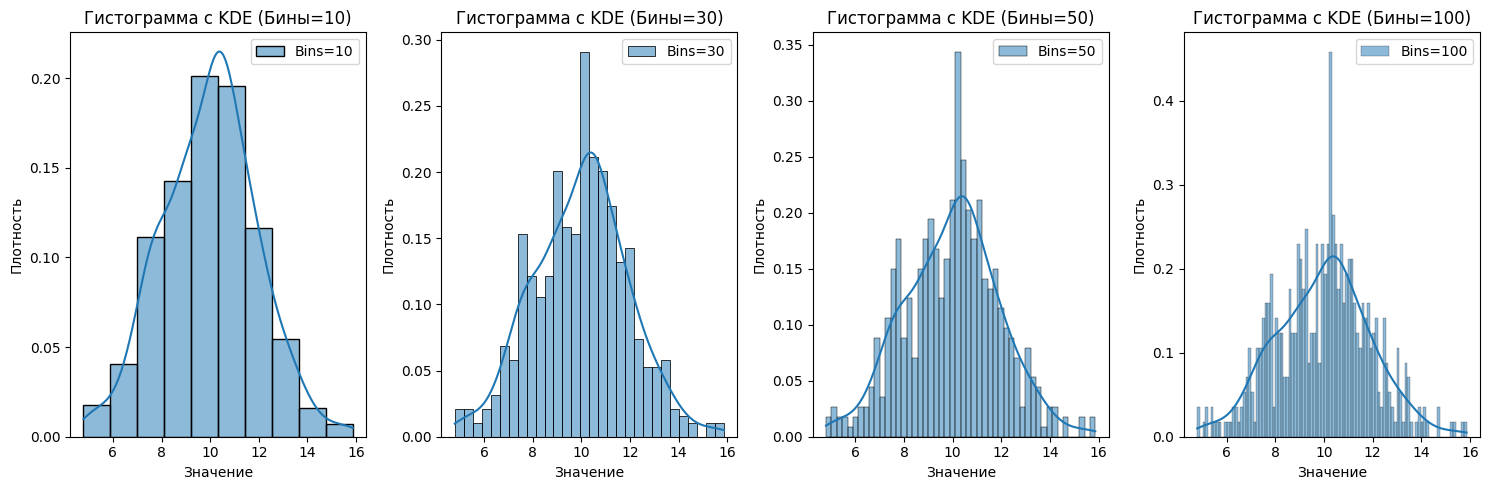

In [4]:
bin_counts = [10, 30, 50, 100] # Different number of bins to compare

plt.figure(figsize=(15, 5))

for i, bins in enumerate(bin_counts):
    plt.subplot(1, len(bin_counts), i + 1)
    sns.histplot(data, bins=bins, kde=True, stat="density", label=f'Bins={bins}')
    plt.title(f'Гистограмма с KDE (Бины={bins})')
    plt.xlabel('Значение')
    plt.ylabel('Плотность')
    plt.legend()

plt.tight_layout()
plt.show()


## Бутстрап для точечных оценок

### Алгоритм бустрапа


In [5]:
def _efron_ci(theta_hat_star: np.ndarray, alpha: float) -> tuple[float, float]:
    """Calculates Efron's (Percentile) bootstrap confidence interval."""
    left, right = np.quantile(theta_hat_star, (alpha / 2, 1 - alpha / 2))
    return (left, right)

def _hall_ci(theta_hat_star: np.ndarray, theta_hat: float, alpha: float) -> tuple[float, float]:
    """Calculates Hall's (Basic) bootstrap confidence interval."""
    diffs = theta_hat_star - theta_hat
    left_diff, right_diff = np.quantile(diffs, (alpha / 2, 1 - alpha / 2))
    ci = (theta_hat - right_diff, theta_hat - left_diff)
    return ci

def _t_percentile_ci(
    bootstrap_samples: np.ndarray,
    theta_hat_star: np.ndarray,
    theta_hat: float,
    X: np.ndarray,
    alpha: float,
    func: Callable[[np.ndarray], float]
) -> tuple[float, float]:
    """
    Calculates Studentized (t-percentile) bootstrap confidence interval.
    Requires standard error estimation for the statistic.
    Implementation is simplified and primarily supports np.mean and np.median
    with approximations for standard error estimation.
    """
    n = X.size

    # Estimate standard error for the original sample statistic
    if func == np.mean:
         se_theta_hat = np.std(X, ddof=1) / np.sqrt(n)
    elif func == np.median:
         # Approximation for SE of median, assumes large N and approx. normal data
         se_theta_hat = 1.253 * np.std(X, ddof=1) / np.sqrt(n)
    else:
         raise NotImplementedError(f"Studentized bootstrap SE estimation is not implemented for function {func.__name__}. Supported: np.mean, np.median (approx).")

    # Estimate standard error for each bootstrap sample statistic
    if func == np.mean:
         se_theta_hat_star = np.std(bootstrap_samples, axis=1, ddof=1) / np.sqrt(n)
    elif func == np.median:
         # Approximation for SE of median for each bootstrap sample
         se_theta_hat_star = 1.253 * np.std(bootstrap_samples, axis=1, ddof=1) / np.sqrt(n)
    else:
         raise ValueError("Internal error: Function should have been caught by SE check.")


    # Avoid division by zero or very small numbers
    se_theta_hat_star[se_theta_hat_star < 1e-9] = 1e-9

    # Studentize bootstrap statistics
    studentized_stats = (theta_hat_star - theta_hat) / se_theta_hat_star

    # Get percentiles of the studentized statistics
    left_studentized, right_studentized = np.quantile(studentized_stats, (alpha / 2, 1 - alpha / 2))

    # CI = [original statistic - upper percentile * original SE, original statistic - lower percentile * original SE]
    ci = (theta_hat - right_studentized * se_theta_hat, theta_hat - left_studentized * se_theta_hat)
    return ci

def get_bootstrap_ci(
    X: np.ndarray,
    func: Callable[[np.ndarray], float],
    N: int = 1000,
    kind: Literal['Efron', 'Hall', 't-percentile'] = 'Efron',
    alpha: float = 0.05
) -> tuple[float, float]:
    """
    Calculates bootstrap confidence interval for a given statistic using specified method.

    Args:
        X: Input data as a numpy array.
        func: The statistic function to apply.
        N: Number of bootstrap samples.
        kind: The method for calculating the confidence interval ('Efron', 'Hall', 't-percentile').
        alpha: The significance level.

    Returns:
        A tuple containing the lower and upper bounds of the confidence interval.

    Raises:
        ValueError: If an unknown method 'kind' is specified or internal error.
        NotImplementedError: If 't-percentile' is selected and standard error estimation
                             is not supported for the function.
    """
    n = X.size
    # Generate N bootstrap samples
    bootstrap_samples = np.random.choice(X, (N, n), replace=True)
    # Compute the statistic for each bootstrap sample
    theta_hat_star = func(bootstrap_samples, axis=1)
    # Compute the statistic for the original sample
    theta_hat = func(X)

    if kind == 'Efron':
        return _efron_ci(theta_hat_star, alpha)
    elif kind == 'Hall':
        return _hall_ci(theta_hat_star, theta_hat, alpha)
    elif kind == 't-percentile':
        # Pass bootstrap_samples and func to the t-percentile function for SE estimation
        return _t_percentile_ci(bootstrap_samples, theta_hat_star, theta_hat, X, alpha, func)
    else:
        raise ValueError(f"Unknown method kind: {kind}. Choose from 'Efron', 'Hall', 't-percentile'.")


def visualize_cis(cis: dict, sample_stat: float, stat_name: str):
    """Visualizes confidence intervals for a given statistic."""
    levels = list(cis.keys())
    intervals = list(cis.values())

    plt.figure(figsize=(8, 5))

    for i, (level, (lower, upper)) in enumerate(zip(levels, intervals)):
        plt.hlines(y=i, xmin=lower, xmax=upper, color='blue', linewidth=2, label=f'{level*100:.0f}% CI')
        plt.plot([lower, upper], [i, i], marker='o', color='blue') # Add markers at ends

    plt.axvline(sample_stat, color='red', linestyle='dashed', linewidth=2, label=f'Выборочная {stat_name}')
    plt.yticks(range(len(levels)), [f'{level*100:.0f}%' for level in levels])
    plt.title(f'Доверительные интервалы для {stat_name} (Процентильный метод)')
    plt.xlabel(f'Значение {stat_name}')
    plt.ylabel('Уровень доверия')
    plt.legend()
    plt.grid(True)
    plt.show()


### Гистограммы распределения бутстрап оценок


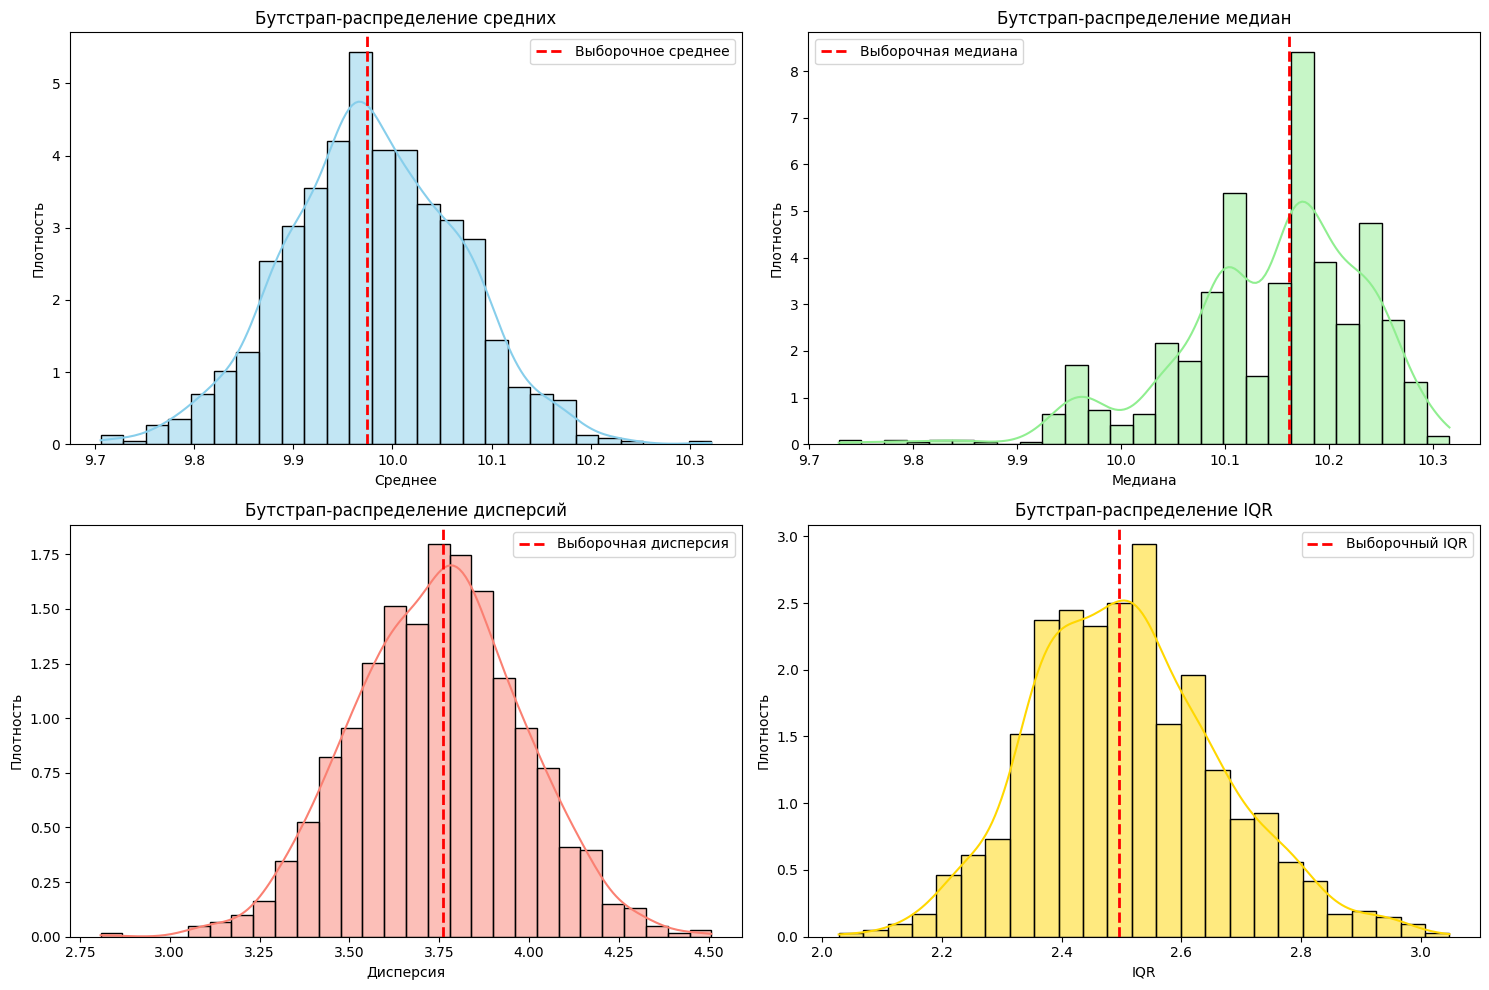

In [6]:
B = 1000 # Number of bootstrap samples

bootstrap_means = []
bootstrap_medians = []
bootstrap_variances = []
bootstrap_iqrs = []

for _ in range(B):
    bootstrap_sample = np.random.choice(data, size=N, replace=True)
    bootstrap_means.append(np.mean(bootstrap_sample))
    bootstrap_medians.append(np.median(bootstrap_sample))
    bootstrap_variances.append(np.var(bootstrap_sample, ddof=1))
    bootstrap_iqrs.append(stats.iqr(bootstrap_sample))

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(bootstrap_means, kde=True, color='skyblue', stat="density")
plt.axvline(sample_mean, color='red', linestyle='dashed', linewidth=2, label='Выборочное среднее')
plt.title('Бутстрап-распределение средних')
plt.xlabel('Среднее')
plt.ylabel('Плотность')
plt.legend()

plt.subplot(2, 2, 2)
sns.histplot(bootstrap_medians, kde=True, color='lightgreen', stat="density")
plt.axvline(sample_median, color='red', linestyle='dashed', linewidth=2, label='Выборочная медиана')
plt.title('Бутстрап-распределение медиан')
plt.xlabel('Медиана')
plt.ylabel('Плотность')
plt.legend()

plt.subplot(2, 2, 3)
sns.histplot(bootstrap_variances, kde=True, color='salmon', stat="density")
plt.axvline(sample_variance, color='red', linestyle='dashed', linewidth=2, label='Выборочная дисперсия')
plt.title('Бутстрап-распределение дисперсий')
plt.xlabel('Дисперсия')
plt.ylabel('Плотность')
plt.legend()

plt.subplot(2, 2, 4)
sns.histplot(bootstrap_iqrs, kde=True, color='gold', stat="density")
plt.axvline(sample_iqr, color='red', linestyle='dashed', linewidth=2, label='Выборочный IQR')
plt.title('Бутстрап-распределение IQR')
plt.xlabel('IQR')
plt.ylabel('Плотность')
plt.legend()

plt.tight_layout()
plt.show()


## Построение доверительных интервалов

### Процентильный метод Efron


In [7]:
confidence_levels = [0.90, 0.95, 0.99]

print("\nПостроение доверительных интервалов (с использованием get_bootstrap_ci, метод Efron):")

# Calculate confidence intervals for Mean
cis_mean = {}
print("\nДоверительные интервалы для Среднего:")
for level in confidence_levels:
    alpha = 1 - level
    ci = get_bootstrap_ci(data, np.mean, N=B, kind='Efron', alpha=alpha)
    cis_mean[level] = ci
    print(f"  {level*100:.0f}% CI: [{ci[0]:.4f}, {ci[1]:.4f}], размер: {ci[1] - ci[0]}")

# Calculate confidence intervals for Median
cis_median = {}
print("\nДоверительные интервалы для Медианы:")
for level in confidence_levels:
    alpha = 1 - level
    ci = get_bootstrap_ci(data, np.median, N=B, kind='Efron', alpha=alpha)
    cis_median[level] = ci
    print(f"  {level*100:.0f}% CI: [{ci[0]:.4f}, {ci[1]:.4f}], размер: {ci[1] - ci[0]}")



Построение доверительных интервалов (с использованием get_bootstrap_ci, метод Efron):

Доверительные интервалы для Среднего:
  90% CI: [9.8357, 10.1091], размер: 0.27331601771802205
  95% CI: [9.8054, 10.1319], размер: 0.3265279727720447
  99% CI: [9.7681, 10.1854], размер: 0.4173858501804304

Доверительные интервалы для Медианы:
  90% CI: [9.9594, 10.2521], размер: 0.292780384268994
  95% CI: [9.9537, 10.2799], размер: 0.3262602728480086
  99% CI: [9.8264, 10.3121], размер: 0.4857455240885642


### Визуализация метода


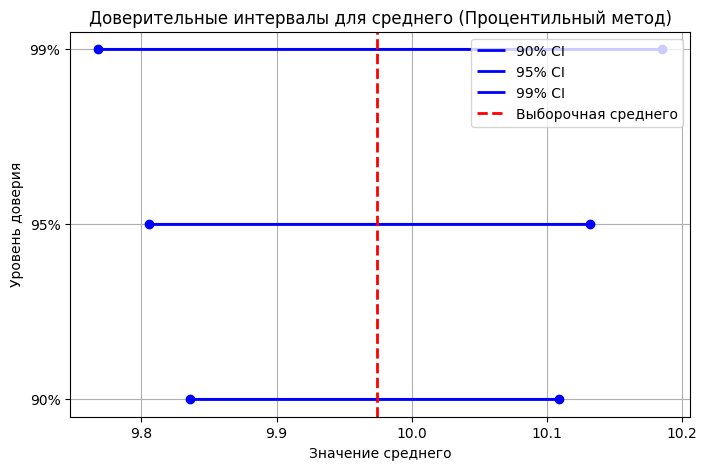

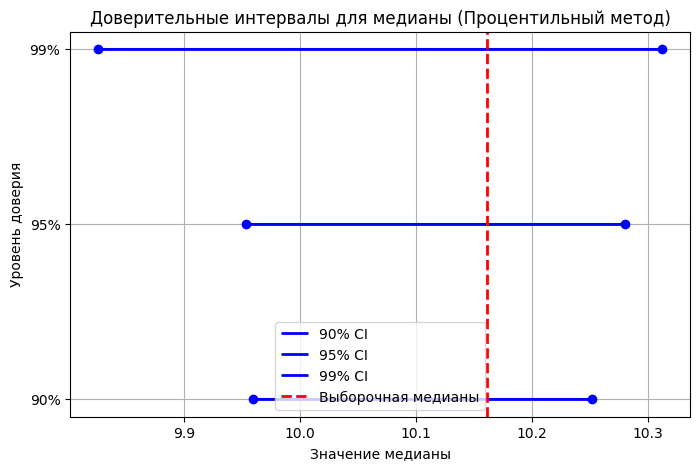

In [ ]:
visualize_cis(cis_mean, sample_mean, 'среднего')
visualize_cis(cis_median, sample_median, 'медианы')

## Влияние объема выборки и числа итераций

### Зависимость от N



Исследование влияния объема выборки (N) на ширину 95% CI среднего (метод Efron):
  N=50, 95% CI width: 1.2331
  N=100, 95% CI width: 0.7594
  N=200, 95% CI width: 0.4980
  N=500, 95% CI width: 0.3417
  N=1000, 95% CI width: 0.2369


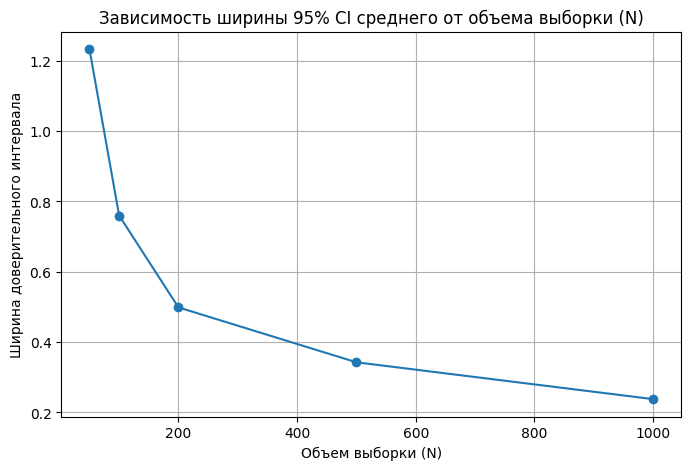

In [ ]:
N_values = [50, 100, 200, 500, 1000]
B_fixed = 1000 # Fixed number of bootstrap iterations
ci_widths_N = []

print("\nИсследование влияния объема выборки (N) на ширину 95% CI среднего (метод Efron):")

for current_N in N_values:
    # Generate data for current N from the true distribution
    current_data = np.random.normal(loc=mu_true, scale=sigma_true, size=current_N)

    # Calculate 95% CI for mean using get_bootstrap_ci (Efron method)
    alpha = 0.05
    ci = get_bootstrap_ci(current_data, np.mean, N=B_fixed, kind='Efron', alpha=alpha)
    ci_widths_N.append(ci[1] - ci[0])
    print(f"  N={current_N}, 95% CI width: {ci_widths_N[-1]:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(N_values, ci_widths_N, marker='o')
plt.title('Зависимость ширины 95% CI среднего от объема выборки (N)')
plt.xlabel('Объем выборки (N)')
plt.ylabel('Ширина доверительного интервала')
plt.grid(True)
plt.show()

### Зависимость от B



Исследование влияния числа бутстрап-итераций (B) на ширину 95% CI среднего (при N=500, метод Efron):
  B=100, 95% CI width: 0.3314
  B=200, 95% CI width: 0.3476
  B=400, 95% CI width: 0.3376
  B=1600, 95% CI width: 0.3600
  B=3200, 95% CI width: 0.3546


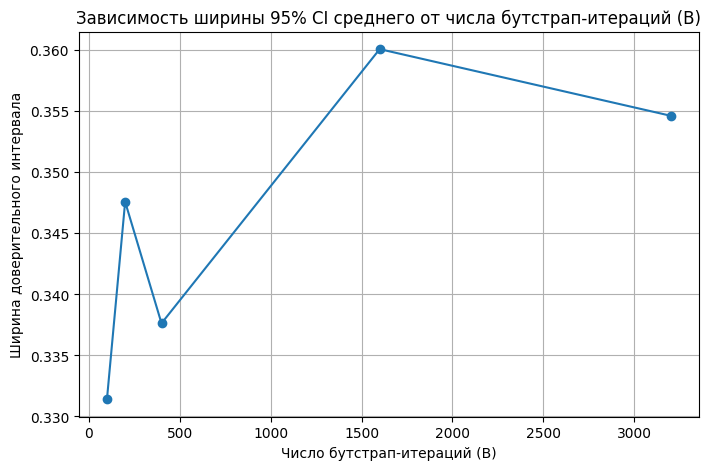

In [ ]:
N_fixed_for_B = 500 # Fixed sample size
B_values = [100, 200, 400, 1600, 3200]
ci_widths_B = []

print("\nИсследование влияния числа бутстрап-итераций (B) на ширину 95% CI среднего (при N=500, метод Efron):")

# Generate data for fixed N for this step
fixed_data_for_B = np.random.normal(loc=mu_true, scale=sigma_true, size=N_fixed_for_B)

for current_B in B_values:
    # Calculate 95% CI for mean using get_bootstrap_ci (Efron method)
    alpha = 0.05
    ci = get_bootstrap_ci(fixed_data_for_B, np.mean, N=current_B, kind='Efron', alpha=alpha)
    ci_widths_B.append(ci[1] - ci[0])
    print(f"  B={current_B}, 95% CI width: {ci_widths_B[-1]:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(B_values, ci_widths_B, marker='o')
plt.title('Зависимость ширины 95% CI среднего от числа бутстрап-итераций (B)')
plt.xlabel('Число бутстрап-итераций (B)')
plt.ylabel('Ширина доверительного интервала')
plt.grid(True)
plt.show()

## Проверка покрытия интервалов

### Для N(0, 1)


In [11]:
N_values_coverage = [50, 100, 200, 500, 1000]
B_values_coverage = [100, 200, 400, 1600, 3200]
num_simulations = 100 # Number of samples to generate for each (N, B) pair
true_mean_coverage = 0 # True mean for N(0, 1)
confidence_level_coverage = 0.95 # 95% CI
alpha_coverage = 1 - confidence_level_coverage

coverage_results = {} # Dictionary to store coverage proportions

print("\nПроверка покрытия 95% доверительных интервалов среднего (для N(0, 1), метод Efron):")

for current_N in N_values_coverage:
    coverage_results[current_N] = {}
    for current_B in B_values_coverage:
        intervals_containing_true_mean = 0

        # Run simulations for the current (N, B) pair
        for _ in range(num_simulations):
            # Generate a new sample from N(0, 1)
            sample_coverage = np.random.normal(loc=0, scale=1, size=current_N)

            # Calculate 95% CI for mean using get_bootstrap_ci (Efron method)
            ci = get_bootstrap_ci(sample_coverage, np.mean, N=current_B, kind='Efron', alpha=alpha_coverage)

            # Check if the interval contains the true mean (0)
            if ci[0] <= true_mean_coverage <= ci[1]:
                intervals_containing_true_mean += 1

        # Calculate coverage proportion
        coverage_proportion = intervals_containing_true_mean / num_simulations
        coverage_results[current_N][current_B] = coverage_proportion
        print(f"  N={current_N}, B={current_B}: Доля покрытия = {coverage_proportion:.4f}")



Проверка покрытия 95% доверительных интервалов среднего (для N(0, 1), метод Efron):
  N=50, B=100: Доля покрытия = 0.8900
  N=50, B=200: Доля покрытия = 0.9500
  N=50, B=400: Доля покрытия = 0.9400
  N=50, B=1600: Доля покрытия = 0.9800
  N=50, B=3200: Доля покрытия = 0.9600
  N=100, B=100: Доля покрытия = 1.0000
  N=100, B=200: Доля покрытия = 0.8900
  N=100, B=400: Доля покрытия = 0.9500
  N=100, B=1600: Доля покрытия = 0.9300
  N=100, B=3200: Доля покрытия = 0.9400
  N=200, B=100: Доля покрытия = 0.9200
  N=200, B=200: Доля покрытия = 0.9100
  N=200, B=400: Доля покрытия = 0.9400
  N=200, B=1600: Доля покрытия = 0.9400
  N=200, B=3200: Доля покрытия = 0.9400
  N=500, B=100: Доля покрытия = 0.9500
  N=500, B=200: Доля покрытия = 0.9000
  N=500, B=400: Доля покрытия = 0.9500
  N=500, B=1600: Доля покрытия = 0.9300
  N=500, B=3200: Доля покрытия = 0.9600
  N=1000, B=100: Доля покрытия = 0.9600
  N=1000, B=200: Доля покрытия = 0.8700
  N=1000, B=400: Доля покрытия = 0.9600
  N=1000, B=

### Таблица


In [12]:
coverage_df = pd.DataFrame(coverage_results)
print("\nТаблица результатов проверки покрытия:")
print(coverage_df)


Таблица результатов проверки покрытия:
      50    100   200   500   1000
100   0.89  1.00  0.92  0.95  0.96
200   0.95  0.89  0.91  0.90  0.87
400   0.94  0.95  0.94  0.95  0.96
1600  0.98  0.93  0.94  0.93  0.90
3200  0.96  0.94  0.94  0.96  0.91


### Heatmap


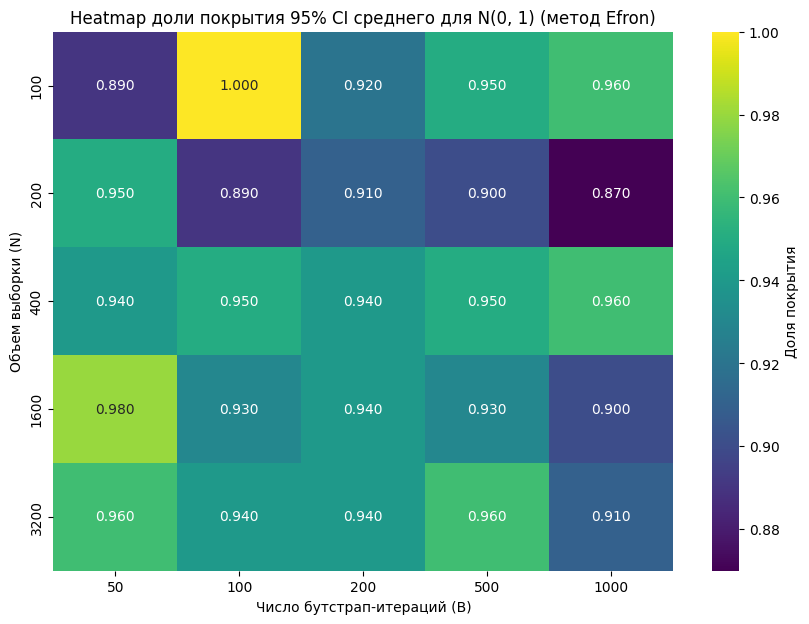

In [13]:
plt.figure(figsize=(10, 7))
sns.heatmap(coverage_df, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Доля покрытия'})
plt.title('Heatmap доли покрытия 95% CI среднего для N(0, 1) (метод Efron)')
plt.xlabel('Число бутстрап-итераций (B)')
plt.ylabel('Объем выборки (N)')
plt.show()